# ADS 509 Assignment 2.1: Tokenization, Normalization, Descriptive Statistics 

This notebook holds Assignment 2.1 for Module 2 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In the previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we explore some of the textual features of those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 

This assignment asks you to write a short function to calculate some descriptive statistics on a piece of text. Then you are asked to find some interesting and unique statistics on your corpora. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation

sw = stopwords.words("english")

In [2]:
# Add any additional import statements you need here

import collections


In [3]:
# I ended up using the M1 Results for Cher and Robyn because my files for Rush and The Killers would not work. I think I
# see now from the feedback on my module 1 HW. 

# change `data_location` to the location of the folder on your machine.
data_location = "./M1 Results/"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

# Section Complete

In [4]:
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
        and num_tokens most common tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters. 
    
    """

    # Fill in the correct values here. I used the len function to get these correct values.
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens/num_tokens
    num_characters = len("".join(tokens))
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens. I think when I ran this the first time a few of these funcitons were flipepd.
        
    return([num_tokens, num_unique_tokens,
            num_characters,
            lexical_diversity
            ])
 
# Section Complete

In [5]:
text = """here is some example text with other example text here in this text""".split()
assert(descriptive_stats(text, verbose=True)[0] == 13)
assert(descriptive_stats(text, verbose=False)[1] == 9)
assert(descriptive_stats(text, verbose=False)[2] == 55)
assert(abs(descriptive_stats(text, verbose=False)[3] - 0.69) < 0.02)


There are 13 tokens in the data.
There are 9 unique tokens in the data.
There are 55 characters in the data.
The lexical diversity is 0.692 in the data.


Q: Why is it beneficial to use assertion statements in your code? 

A: To perform a sanity check during the development. 

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [6]:
# Read in the lyrics data

root_path = "./M1 Results/lyrics"
lyric_data = dict()
for dir_name in os.listdir(root_path):
    if dir_name != ".DS_Store":
        file_path = root_path+'/'+dir_name
        lyric_data[dir_name] = dict()
        for file_name in os.listdir(file_path):
            full_file_path = file_path+'/'+file_name
            with open(full_file_path, 'r') as f:
                text = f.read()
                title = text.split("\n")[0].strip('"')
                artist = dir_name
                lyric_data[artist][title] = text
        print(f"Read lyrics: {len(lyric_data[artist].keys())} songs of {dir_name}")
        
# Section Complete

Read lyrics: 313 songs of cher
Read lyrics: 93 songs of robyn


In [7]:
# To make it easier to use further down I read this into a pandas df.

lyric_df = (pd.DataFrame(lyric_data)
            .reset_index()
            .rename(columns = {'index':'title'}))
lyric_df.loc[lyric_df['robyn'].isnull()==False,'artist'] = 'robyn'
lyric_df.loc[lyric_df['cher'].isnull()==False,'artist'] = 'cher'
lyric_df.loc[lyric_df['robyn'].isnull()==False,'lyric'] = lyric_df['robyn']
lyric_df.loc[lyric_df['cher'].isnull()==False,'lyric'] = lyric_df['cher']
lyric_df.drop(['cher','robyn'],axis = 1, inplace=True)
lyric_df.head()

# Section Complete

,title,artist,lyric
0,88 Degrees,cher,"""88 Degrees""\n\n\n\nStuck in L.A., ain't got n..."
1,A Different Kind Of Love Song,cher,"""A Different Kind Of Love Song""\n\n\n\nWhat if..."
2,After All,cher,"""After All""\n\n\n\nWell, here we are again\nI ..."
3,Again,cher,"""Again""\n\n\n\nAgain evening finds me at your ..."
4,Alfie,cher,"""Alfie""\n\n\n\nWhat's it all about, Alfie?\nIs..."


In [8]:
# Read in the twitter data

root_path = "./M1 Results/twitter"
twitter_data = list()
for file_name in os.listdir(root_path):
    if 'data' in file_name:
        file_path = root_path+'/'+file_name
        columns = ['screen_name','name','id','location','followers_count','friends_count','description']
        df = pd.read_csv(file_path,sep='\\t',engine='python')
        df['following'] = file_name.split("_followers")[0]
        twitter_data.append(df[['following','description']])
        print(f"Read file:{file_path}",f"{df.shape[0]} rows")
        
twitter_df = pd.concat(twitter_data,axis=0).fillna(" ")
print(f"Create dataframe: {twitter_df.shape[0]} rows in total.")

# Section Complete

Read file:./M1 Results/twitter/cher_followers_data.txt 3994803 rows
Read file:./M1 Results/twitter/robynkonichiwa_followers_data.txt 358372 rows
Create dataframe: 4353175 rows in total.


In [9]:
# To validate that I created the twitter df with following as the index of which artist the follower is following:

twitter_df.head()

# Section Complete

,following,description
0,cher,
1,cher,ð�™¿ð�š›ð�š˜ð�šžð�š� ð�šœð�šžð�š™ð�š™ð�š˜ð�š›ð...
2,cher,163ãŽ�ï¼�æ„›ã�‹ã�£ã�·ðŸ’œ26æ­³ðŸ�’ å·¥ã€‡å¥½ã�...
3,cher,csu
4,cher,Writer @Washinformer @SpelmanCollege alumna #D...


## Data Cleaning

Now clean and tokenize your data. Remove punctuation chacters (available in the `punctuation` object in the `string` library), split on whitespace, fold to lowercase, and remove stopwords. Store your cleaned data, which must be accessible as an interable for `descriptive_stats`, in new objects or in new columns in your data frame. 



In [10]:
punctuation = set(punctuation) # speeds up comparison
print(punctuation)

{'*', ':', '|', ';', '^', '=', '<', '$', '.', "'", '/', '+', '[', '#', '`', '!', '\\', ',', '>', '?', '@', '%', '(', '&', '{', '}', ')', '_', '"', '~', ']', '-'}


In [11]:
# Create funcitons to help with the cleaning as asked above:

def remove_stop(tokens):
    stopwords = set(nltk.corpus.stopwords.words('english'))
    return [t for t in tokens if t.lower() not in stopwords]

def tokenize(text):
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    tokens = tokenizer.tokenize(text)
    return [t for t in tokens if t.isalpha()]

def remove_punctuation(tokens):
    return [t for t in tokens if t not in set(punctuation)]

def remove_letterlike_symbol(tokens):
    """
    e.g. Japenese, Korean...
    """
    return [t for t in tokens if t.isascii()]

pipeline = [str.lower, tokenize, remove_punctuation, remove_stop,remove_letterlike_symbol]
def prepare(text, pipeline): 
    tokens = text
    for transform in pipeline: 
        tokens = transform(tokens)
    return " ".join(tokens)

# Section Complete

In [13]:
import nltk

In [14]:
# create your clean twitter data here

twitter_df['description_token']=twitter_df['description'].apply(prepare,pipeline=pipeline)
twitter_df['description_token'].head()

# Section Complete

0                                                     
1                                                     
2                                                     
3                                                  csu
4    writer washinformer spelmancollege alumna dcna...
Name: description_token, dtype: object

In [15]:
# create your clean lyrics data here

lyric_df['lyric_token']=lyric_df['lyric'].apply(prepare,pipeline=pipeline)
lyric_df['lyric_token'].head()


0    degrees stuck l got friends hollywood nuts man...
1    different kind love song world crazy sane woul...
2    well guess must fate tried deep inside known b...
3    evening finds door ask could try know quite sa...
4    alfie alfie moment live sort alfie meant take ...
Name: lyric_token, dtype: object

In [16]:
lyric_df['title_token']=lyric_df['title'].apply(prepare,pipeline=pipeline)
lyric_df['title_token'].head()

# Section Complete

0                     degrees
1    different kind love song
2                            
3                            
4                       alfie
Name: title_token, dtype: object

## Basic Descriptive Statistics

Call your `descriptive_stats` function on both your lyrics data and your twitter data and for both artists (four total calls). 

In [17]:
# calls to descriptive_stats here
# I'm starting by breaking this up first for lyrics of Robyn:

text = " ".join(lyric_df[lyric_df['artist']=="robyn"]['lyric_token'].tolist()).split()
print("Lyrics by Artist: robyn")
descriptive_stats(text, verbose=True)

Lyrics by Artist: robyn
There are 11877 tokens in the data.
There are 2053 unique tokens in the data.
There are 58057 characters in the data.
The lexical diversity is 0.173 in the data.


[11877, 2053, 58057, 0.17285509808874294]

In [18]:
# Now for cher:

text = " ".join(lyric_df[lyric_df['artist']=="cher"]['lyric_token'].tolist()).split()
print("Lyrics by Artist: cher")
descriptive_stats(text, verbose=True)

Lyrics by Artist: cher
There are 32601 tokens in the data.
There are 3527 unique tokens in the data.
There are 158050 characters in the data.
The lexical diversity is 0.108 in the data.


[32601, 3527, 158050, 0.10818686543357565]

In [19]:
# Now to break down the descriptive stats for followers of Robyn:

text = " ".join(twitter_df[twitter_df['following']=="robynkonichiwa"]['description_token'].tolist()).split()
print("Twitter Followers of robynkonichiwa")
descriptive_stats(text, verbose=True)

Twitter Followers of robynkonichiwa
There are 1402208 tokens in the data.
There are 155185 unique tokens in the data.
There are 8128442 characters in the data.
The lexical diversity is 0.111 in the data.


[1402208, 155185, 8128442, 0.11067188320135102]

In [20]:
# Descriptive stats for followers of cher:

text = " ".join(twitter_df[twitter_df['following']=="cher"]['description_token'].tolist()).split()
print("Twitter Followers of cher")
descriptive_stats(text, verbose=True)

Twitter Followers of cher
There are 14331010 tokens in the data.
There are 617321 unique tokens in the data.
There are 82829471 characters in the data.
The lexical diversity is 0.043 in the data.


[14331010, 617321, 82829471, 0.043075889277866666]

Q: How do you think the "top 5 words" would be different if we left stopwords in the data? 

A: I think the top 5 words would change to include the stop words. I think this would not be useful to include that is why we drop them.

---

Q: What were your prior beliefs about the lexical diversity between the artists? Does the difference (or lack thereof) in lexical diversity between the artists conform to your prior beliefs? 

A: I don't know too much about these artists so my initial thought would be that they would have similar lexical diversity. I was wrong because we can see that Roby has a higher lexical diversity compared to cher.



## Specialty Statistics

The descriptive statistics we have calculated are quite generic. You will now calculate a handful of statistics tailored to these data.

1. Ten most common emojis by artist in the twitter descriptions.
1. Ten most common hashtags by artist in the twitter descriptions.
1. Five most common words in song titles by artist. 
1. For each artist, a histogram of song lengths (in terms of number of tokens) 

We can use the `emoji` library to help us identify emojis and you have been given a function to help you.


In [21]:
def is_emoji(s):
    return(s in emoji.UNICODE_EMOJI['en'])

assert(is_emoji("❤️"))
assert(not is_emoji(":-)"))

### Emojis 😁

What are the ten most common emojis by artist in the twitter descriptions? 


In [22]:
# Your code here, first for robyn

text = " ".join(twitter_df[twitter_df['following']=="robynkonichiwa"]['description'].tolist()).split()
emojis = [x for x in text if is_emoji(x)]
counter=collections.Counter(emojis)
print("Ten most common emojis by robynkonichiwa")
print(counter.most_common(10))



Ten most common emojis by robynkonichiwa
[]


In [23]:
#Emojis for cher:

text = " ".join(twitter_df[twitter_df['following']=="cher"]['description'].tolist()).split()
emojis = [x for x in text if is_emoji(x)]
counter=collections.Counter(emojis)
print("Ten most common emojis by cher")
print(counter.most_common(10))

# Section Complete

Ten most common emojis by cher
[('™', 1)]


### Hashtags

What are the ten most common hashtags by artist in the twitter descriptions? 


In [24]:
# Your code here, first for Robyn:

text = " ".join(twitter_df[twitter_df['following']=="robynkonichiwa"]['description'].tolist()).split()
hashtags = [x for x in text if x[0]=='#']
counter=collections.Counter(hashtags)
print("Ten most common hashtags by robynkonichiwa")
print(counter.most_common(10))

Ten most common hashtags by robynkonichiwa
[('#BlackLivesMatter', 311), ('#BLM', 273), ('#blacklivesmatter', 200), ('#1', 187), ('#music', 150), ('#', 150), ('#Music', 93), ('#EDM', 79), ('#blm', 51), ('#TeamFollowBack', 51)]


In [25]:
# Now hashtags for cher:

text = " ".join(twitter_df[twitter_df['following']=="cher"]['description'].tolist()).split()
hashtags = [x for x in text if x[0]=='#']
counter=collections.Counter(hashtags)
print("Ten most common hashtags by cher")
print(counter.most_common(10))

# Section Complete

Ten most common hashtags by cher
[('#BLM', 7920), ('#Resist', 5007), ('#BlackLivesMatter', 4226), ('#resist', 3134), ('#FBR', 2768), ('#blacklivesmatter', 2464), ('#TheResistance', 2459), ('#1', 2226), ('#', 1965), ('#Resistance', 1518)]


### Song Titles

What are the five most common words in song titles by artist? The song titles should be on the first line of the lyrics pages, so if you have kept the raw file contents around, you will not need to re-read the data.


In [26]:
# Your code here
# After removing stopwords for robyn:

text = " ".join(lyric_df[lyric_df['artist']=="robyn"]['title_token'].tolist()).split()
counter=collections.Counter(text)
print("Five most common words by robyn")
print(counter.most_common(10))


Five most common words by robyn
[('love', 5), ('thing', 3), ('girl', 3), ('u', 3), ('like', 2), ('baby', 2), ('music', 2), ('woman', 2), ('girlfriend', 2), ('get', 2)]


In [27]:
# After removing stopwords for cher:

text = " ".join(lyric_df[lyric_df['artist']=="cher"]['title_token'].tolist()).split()
counter=collections.Counter(text)
print("Five most common words by cher")
print(counter.most_common(10))

# Section Complete

Five most common words by cher
[('love', 36), ('man', 15), ('song', 11), ('come', 7), ('one', 7), ('believe', 6), ('heart', 6), ('time', 6), ('go', 6), ('know', 6)]


### Song Lengths

For each artist, a histogram of song lengths (in terms of number of tokens). If you put the song lengths in a data frame with an artist column, matplotlib will make the plotting quite easy. An example is given to help you out. 


artist
Artist 1    AxesSubplot(0.125,0.125;0.775x0.755)
Artist 2    AxesSubplot(0.125,0.125;0.775x0.755)
Name: length, dtype: object

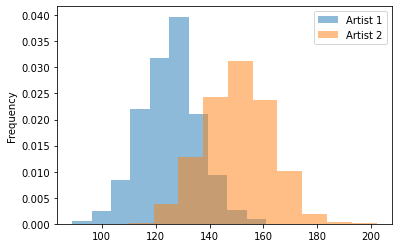

In [28]:
num_replicates = 1000

df = pd.DataFrame({
    "artist" : ['Artist 1'] * num_replicates + ['Artist 2']*num_replicates,
    "length" : np.concatenate((np.random.poisson(125,num_replicates),np.random.poisson(150,num_replicates)))
})

df.groupby('artist')['length'].plot(kind="hist",density=True,alpha=0.5,legend=True)

Since the lyrics may be stored with carriage returns or tabs, it may be useful to have a function that can collapse whitespace, using regular expressions, and be used for splitting. 

Q: What does the regular expression `'\s+'` match on? 

A: It will match 1 or more repitions of whitespace with the above regular expression.


In [29]:
collapse_whitespace = re.compile(r'\s+')

def tokenize_lyrics(lyric) : 
    """strip and split on whitespace"""
    return([item.lower() for item in collapse_whitespace.split(lyric)])

artist
cher     AxesSubplot(0.125,0.125;0.775x0.755)
robyn    AxesSubplot(0.125,0.125;0.775x0.755)
Name: length, dtype: object

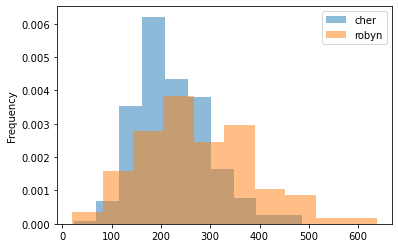

In [30]:
# Your lyric length comparison chart here. 

lyric_df['lyric_split_length'] = lyric_df['lyric'].apply(lambda x: len(tokenize_lyrics(x)))
lyric_df.head()

df = pd.DataFrame({
    "artist" : lyric_df['artist'],
    "length" : lyric_df['lyric_split_length']
})

df.groupby('artist')['length'].plot(kind="hist",density=True,alpha=0.5,legend=True)